**Завдання:**

Протестуйте описані в лекції методи і моделі на датасеті AirPassenger, що міститься н GitHub в папці лекції та містить дані про коливання кількості пасажирів авіаліній із часом. Порівняйте метрики оцінки моделі для двох датасетів.

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import warnings
warnings.filterwarnings("ignore")

In [22]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [58]:
import statsmodels.api as sm

In [39]:
df = pd.read_csv('AirPassengers.csv', index_col=['Month'])
df.index = pd.to_datetime(df.index)

print(f"Датасет має наступні розміри: {df.shape}\n")
print("Приклад датасету:\n")
display(df.head(10))

Датасет має наступні розміри: (144, 1)

Приклад датасету:



,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


In [40]:
display(df.describe())

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [41]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


None

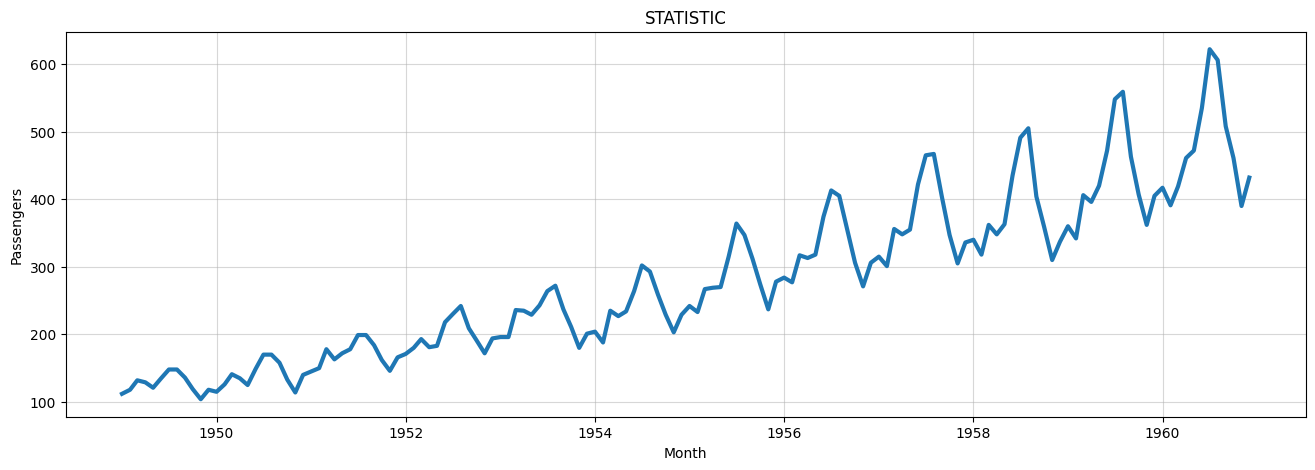

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))
plt.plot(df.index, df['Passengers'], linewidth=3)
plt.title("STATISTIC")
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.grid(axis='y', alpha=0.5)
plt.grid(axis='x', alpha=0.5)

plt.show()

In [45]:
acf_value = acf(df.Passengers)
display(acf_value)

array([1.        , 0.94804734, 0.87557484, 0.80668116, 0.75262542,
       0.71376997, 0.6817336 , 0.66290439, 0.65561048, 0.67094833,
       0.70271992, 0.74324019, 0.76039504, 0.71266087, 0.64634228,
       0.58592342, 0.53795519, 0.49974753, 0.46873401, 0.44987066,
       0.4416288 , 0.45722376])

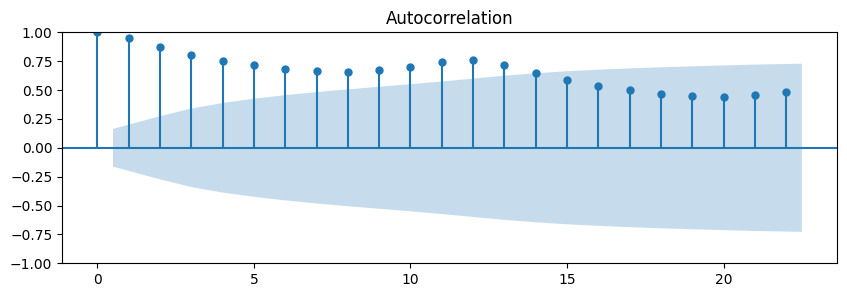

In [46]:
matplotlib.rcParams['figure.figsize']=[10,3]
plot_acf(df.Passengers)
pyplot.show()

In [47]:
pacf_value = pacf(df.Passengers, nlags=3)
display(pacf_value)

array([ 1.        ,  0.95467704, -0.26527732,  0.05546955])

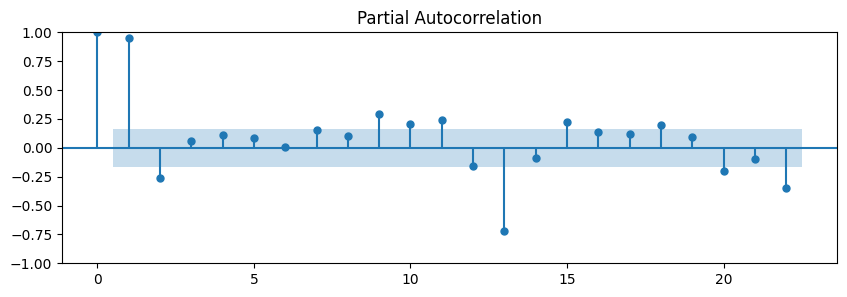

In [48]:
matplotlib.rcParams['figure.figsize']=[10,3]
plot_pacf(df.Passengers)
pyplot.show()

# ARIMA

In [105]:
src_data_model = df.Passengers[:"1959"]
model = sm.tsa.ARIMA(src_data_model, order=(1, 0, 2)).fit()

model.summary()

C:\users\админ\appdata\local\programs\python\python311\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\админ\appdata\local\programs\python\python311\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\админ\appdata\local\programs\python\python311\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  132
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -633.095
Date:                Thu, 16 Mar 2023   AIC                           1276.191
Time:                        22:38:44   BIC                           1290.605
Sample:                    01-01-1949   HQIC                          1282.048
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        262.4967     60.909      4.310      0.000     143.118     381.875
ar.L1          0.9623      0.026     37.129      0.000       0.912       1.013
ma.L1          0.4029      0.081      4.987      0.000       0.245       0.561
ma.L2         -0.3263      0.072     -4.534      0.000      -0.467      -0.185
sigma2       835.8456    101.859      8.206      0.000     636.205    1035.486
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.41
Prob(Q):                              0.82   Prob(JB):                         0.81
Heteroskedasticity (H):               7.05   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

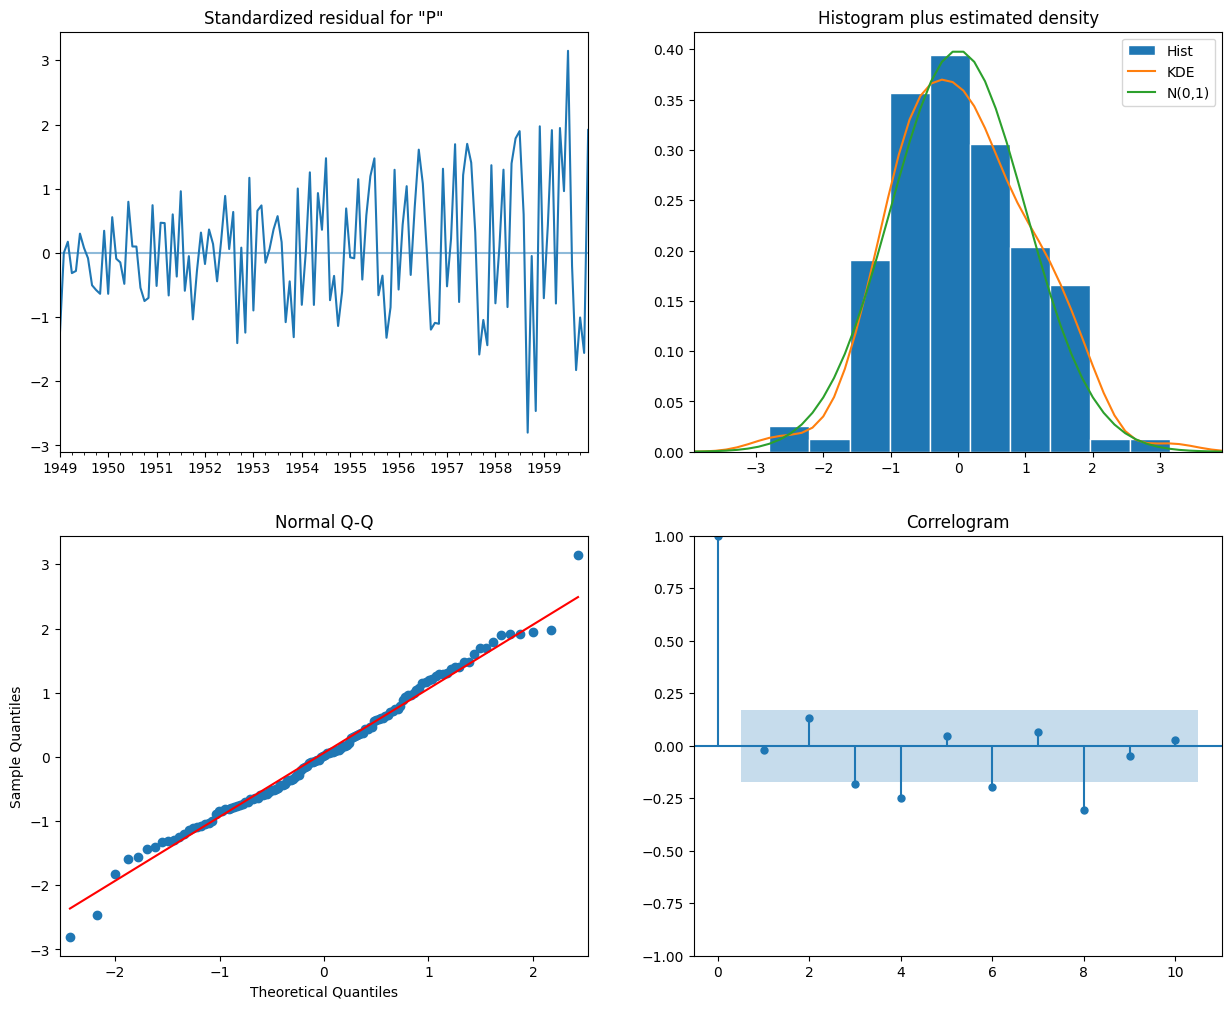

In [110]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [106]:
pred = model.predict('1959', '1960-12-01', typ='levels')

<AxesSubplot: xlabel='Month'>

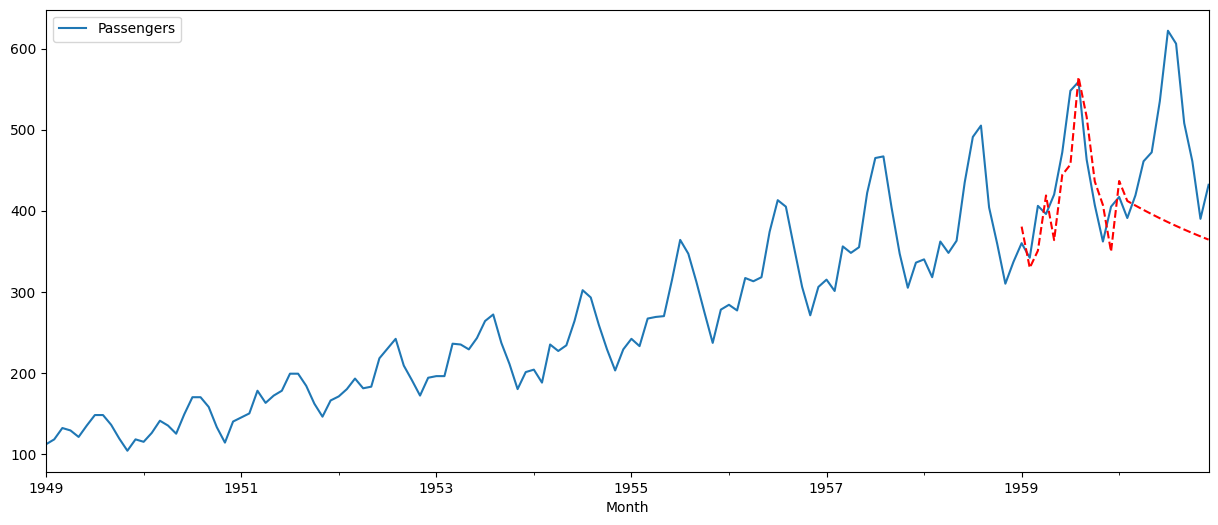

In [107]:
df.plot(figsize=(15, 6))
pred.plot(style='r--')

**З даного графіку чітко видно похибку моделі ARIMA на сезонному коливанні часового ряду, яке дана модель не враховує.**

In [108]:
import ml_metrics as metrics

comp = df.Passengers['1959':]
metrics.mae(comp, pred)

65.75028356599269

In [109]:
metrics.rmse(comp, pred)

89.60727061387264

# SARIMAX

Text(0.5, 1.05, 'Additive-increasing model')

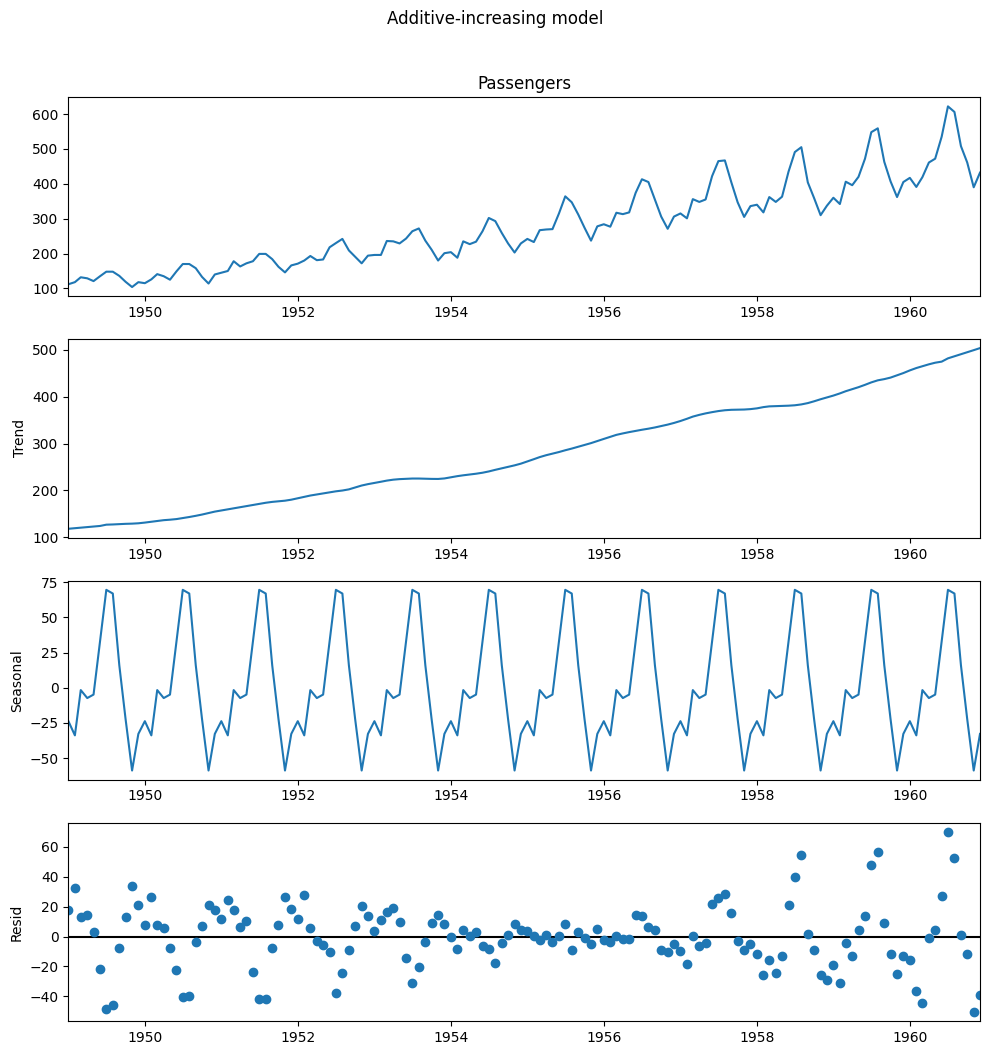

In [71]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_A = seasonal_decompose(df.Passengers, model='additive-increasing', extrapolate_trend=12)

plt.rcParams.update({'figure.figsize': (10,10)})
result_A.plot().suptitle('Additive-increasing model', y=1.05)

In [73]:
from pmdarima import auto_arima

model = auto_arima(df[:'1959'], seasonal=True, m=12, trace=True, suppress_warnings=True, error_action='ignore')
model

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.96 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=0.37 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.35 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=1.12 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.38 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.92 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.29 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=0.52 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.15 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=0.39 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC

ARIMA(order=(3, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True)

In [74]:
mod = sm.tsa.statespace.SARIMAX(df[:'1959'], order=(3, 0, 0), seasonal_order=(0, 1, 0, 12))
results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7603      0.088      8.672      0.000       0.588       0.932
ar.L2          0.2875      0.133      2.164      0.030       0.027       0.548
ar.L3         -0.0823      0.109     -0.752      0.452      -0.297       0.132
sigma2       107.0022     13.170      8.125      0.000      81.190     132.814


C:\users\админ\appdata\local\programs\python\python311\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\users\админ\appdata\local\programs\python\python311\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


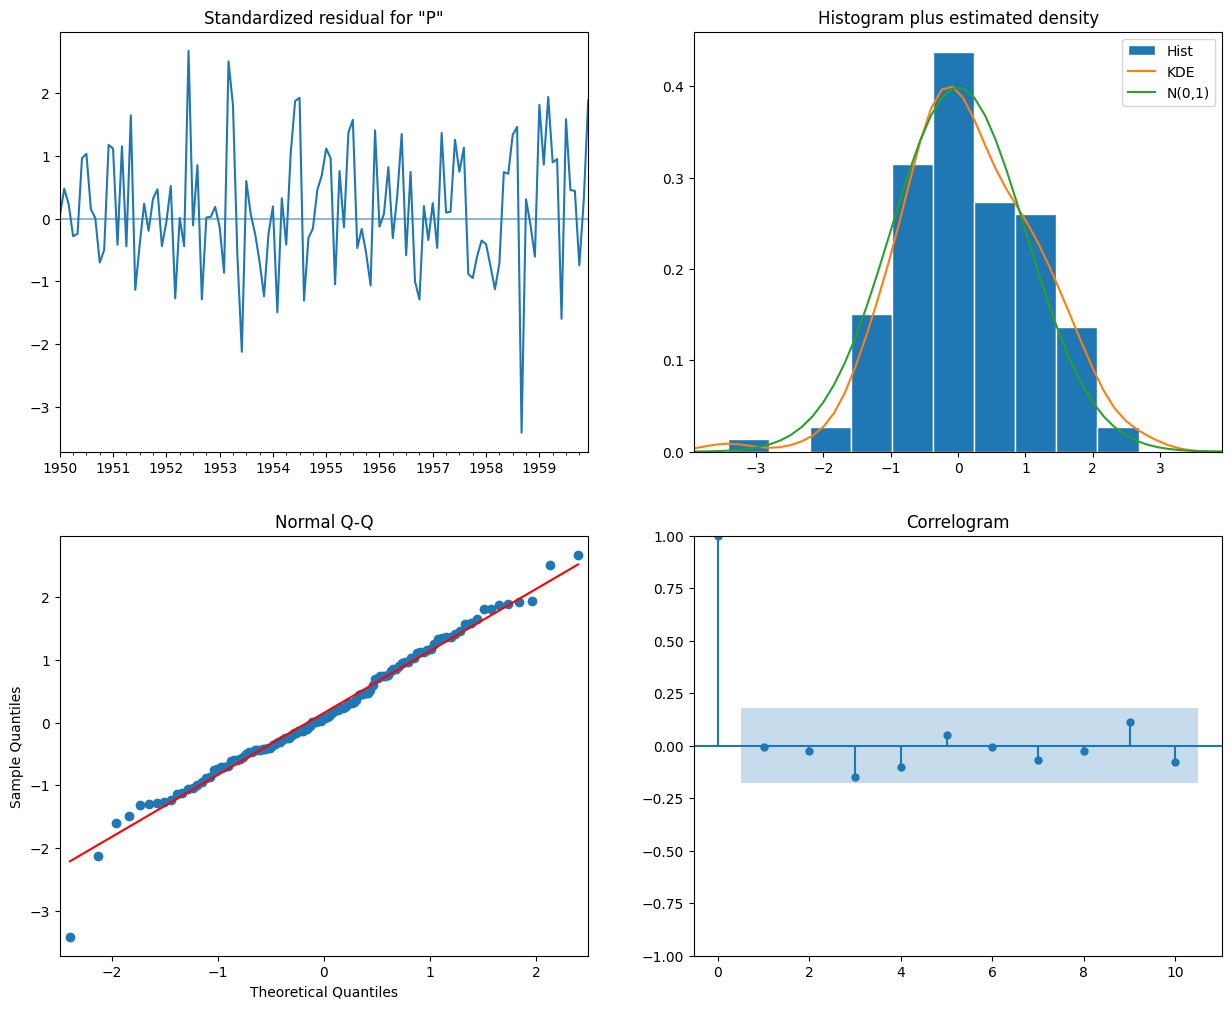

In [75]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [89]:
pred = results.predict('1959', '1960-12-01', typ='levels')

<AxesSubplot: xlabel='Month'>

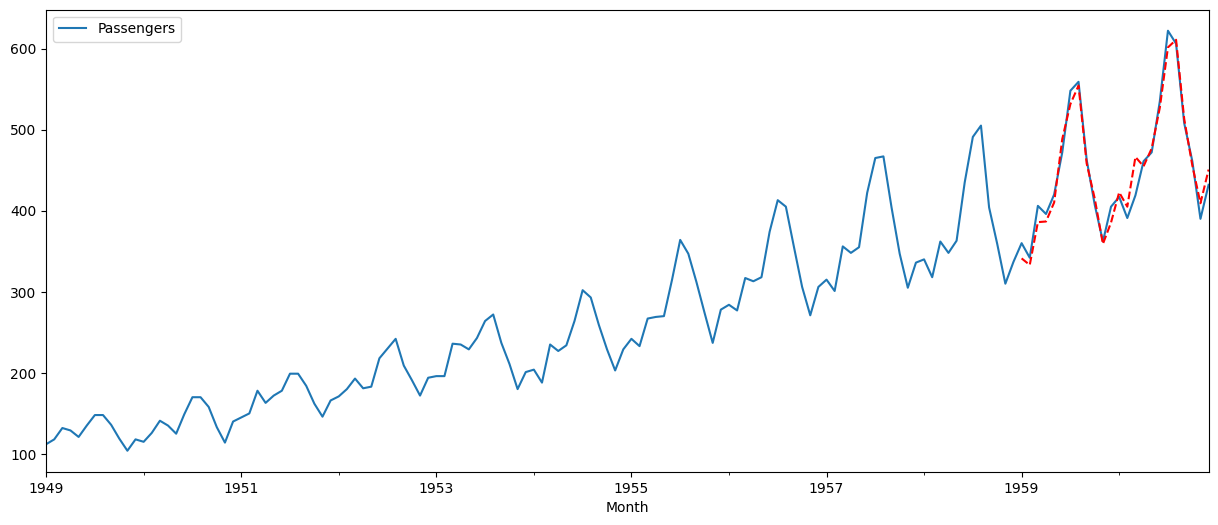

In [91]:
df.plot(figsize=(15, 6))
pred.plot(style='r--')

In [92]:
metrics.rmse(comp, pred)

15.629563575906367

In [93]:
metrics.mae(comp, pred)

12.46161248904093

**Для даного часового ряду, якість моделі SARIMAX (яка враховує сезонність, тренд, екзогенні фактори) на порядок вище моделі ARIMA (яка враховує тільки тренд).**